# Generate cross-correlation function between 2 given catalogs

In [1]:
import os
import tempfile
import time
import copy

import numpy as np
import scipy
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 12})

from pypower import CatalogMesh, MeshFFTPower, CatalogFFTPower, PowerSpectrumStatistics, utils, setup_logging
from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, BoxSubsampler, project_to_wp, utils, setup_logging
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
from cosmoprimo import *

# To activate logging
setup_logging()

### Output directory

In [2]:
output_dir = '/feynman/work/dphp/mp270220/outputs/'

### Get halo catalog

In [3]:
# 1 Gpc/h
path_to_sim_1 = '/feynman/scratch/dphp/ar264273/Abacus/AbacusSummit_highbase_c000_ph100/halos/z1.175'

# 2 Gpc/h
path_to_sim_2_z1 = '/feynman/scratch/dphp/ar264273/Abacus/AbacusSummit_base_c000_ph000/halos/z1.175'
path_to_sim_2_z2 = '/feynman/scratch/dphp/ar264273/Abacus/AbacusSummit_base_c000_ph000/halos/z0.800'

path_to_sim = [path_to_sim_1,
               path_to_sim_2_z1,
               path_to_sim_2_z2]

catalog_names = ['AbacusSummit_highbase_c000_ph100_z1.175',
                 'AbacusSummit_base_c000_ph000_z1.175',
                 'AbacusSummit_base_c000_ph000_z0.800']

sim_z = [1.175, 1.175, 0.800]
sim_boxsizes = [1000, 2000, 2000]

# Simulation to use
sim_index = 1

# Whether to apply RSD or not
RSD = False
RSD_string = ''
rsd_info = 'real space'
if RSD:
    RSD_string = '_wRSD'
    rsd_info = 'redshift space'

In [4]:
boxsize = sim_boxsizes[sim_index]
z = sim_z[sim_index]

In [5]:
# density split names
subset_names = ['D1', 'D2']
split_catalogs_meshes = list()
split_catalogs_positions = list()
cellsize = 20
size = 10000000
resampler = 'tsc'

for i in range(len(subset_names)):
    split_catalogs_meshes.append(np.load(output_dir+catalog_names[sim_index]+RSD_string+'_'+subset_names[i]+'_meshes_'+resampler+'.npy'))
    
    split_catalogs_positions.append(np.load(output_dir+catalog_names[sim_index]+RSD_string+'_'+subset_names[i]+'_positions_'+resampler+'.npy'))
    
    #split_catalogs_positions.append(np.load(output_dir+catalog_names[sim_index]+RSD_string+'_'+subset_names[i]+'_'+str(size)+'_random_positions_'+resampler+'.npy'))

In [6]:
catalog_positions = np.load(output_dir+catalog_names[sim_index]+RSD_string+'_positions.npy')
data_size = np.shape(catalog_positions)[1]

### Generate random catalogs

In [7]:
# Generate random catalogs to compare catalog with when computing correlation function
def generate_catalogs(size=10000, boxsize=(boxsize,)*3, offset=(boxsize,0.,0.), seed=42):
    rng = np.random.RandomState(seed=seed)
    positions = [o + rng.uniform(0., 1., size)*b for o, b in zip(offset, boxsize)]
    return positions
    
catalog_randoms_positions = generate_catalogs(size=6*data_size, boxsize=(boxsize,)*3, offset=(-boxsize/2.,-boxsize/2.,-boxsize/2.))

### Generate random points within a specific area

In [8]:
# Generate random catalogs to compare catalog with when computing correlation function
def generate_catalog_in_area(area, size=10000, boxsize=(boxsize,)*3, offset=(boxsize,0.,0.), cellsize=1, nmesh=boxsize, seed=42):
    rng = np.random.RandomState(seed=seed)
    positions = [o + rng.uniform(0., 1., size)*b for o, b in zip(offset, boxsize)]
    nmesh = round(boxsize[0]/cellsize)
    positions_grid_indices = ((np.array(positions)+cellsize/2.) // cellsize).astype(int) % nmesh    
    positions_grid_indices[positions_grid_indices==nmesh] = nmesh-1
    positions_in_area = area[tuple(positions_grid_indices.tolist())]
    return np.array(positions).T[positions_in_area].T, np.array(positions).T[np.logical_not(positions_in_area)].T

#split_randoms_positions = generate_catalog_in_area(split_catalogs_meshes[0], size=6*data_size, boxsize=(boxsize,)*3, offset=(0, 0, 0), cellsize=cellsize, seed=42)

In [ ]:
split_randoms_positions = generate_catalogs(size=6*data_size, boxsize=(boxsize,)*3, offset=(-boxsize/2.,-boxsize/2.,-boxsize/2.), seed=44)

### Correlation function of each density split

In [ ]:
edges = (np.linspace(0., 150., 51), np.linspace(-1, 1, 201))

results = list()

for i in range(len(subset_names)):
    result = TwoPointCorrelationFunction('smu', edges, 
                                         data_positions1=split_catalogs_positions[i], data_positions2=catalog_positions,
                                         randoms_positions1=split_randoms_positions[i], randoms_positions2=catalog_randoms_positions,
                                         engine='corrfunc', nthreads=128,
                                         los = 'x')
    
#    result = TwoPointCorrelationFunction('smu', edges, 
#                                         data_positions1=split_catalogs_positions[i], data_positions2=catalog_positions,
#                                         boxsize=boxsize,
#                                         engine='corrfunc', nthreads=128,
#                                         los = 'x')

    results.append(result)

    # save result
    result.save(output_dir+catalog_names[sim_index]+RSD_string+'_randomx6_CCF_galaxySplit_'+resampler+'_'+subset_names[i]+'_woJackknife_wRandoms')
    #result.save(output_dir+catalog_names[sim_index]+RSD_string+'_randomx6_CCF_galaxySplit_'+resampler+'_'+subset_names[i]+'_randoms_woJackknife_wRandoms')

[000048.46]  04-20 17:37  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000048.46]  04-20 17:37  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000048.51]  04-20 17:37  numexpr.utils                INFO     Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[000048.51]  04-20 17:37  numexpr.utils                INFO     Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[000048.51]  04-20 17:37  numexpr.utils                INFO     NumExpr defaulting to 8 threads.
[000092.17]  04-20 17:37  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000371.09]  04-20 17:42  TwoPointCorrelationFunction  INFO     Computing two-point counts R1D2.
[000423.08]  04-20 17:43  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.


In [15]:
results_load = list()

for i in range(len(subset_names)):
    result = TwoPointCorrelationFunction.load(output_dir+catalog_names[sim_index]+RSD_string+'_randomx6_CCF_galaxySplit_'+resampler+'_'+subset_names[i]+'_randoms_woJackknife_wRandoms.npy')
    results_load.append(result)

[059653.29]  04-21 10:10  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/AbacusSummit_base_c000_ph000_z1.175_randomx6_CCF_galaxySplit_tsc_D1_randoms_woJackknife_wRandoms.npy.
[059653.36]  04-21 10:10  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/AbacusSummit_base_c000_ph000_z1.175_randomx6_CCF_galaxySplit_tsc_D2_randoms_woJackknife_wRandoms.npy.


In [16]:
results_load_gg = list()

for i in range(len(subset_names)):
    result = TwoPointCorrelationFunction.load(output_dir+catalog_names[sim_index]+RSD_string+'_randomx6_CCF_galaxySplit_'+resampler+'_'+subset_names[i]+'_woJackknife_wRandoms.npy')
    results_load_gg.append(result)

[059653.93]  04-21 10:10  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/AbacusSummit_base_c000_ph000_z1.175_randomx6_CCF_galaxySplit_tsc_D1_woJackknife_wRandoms.npy.
[059653.93]  04-21 10:10  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/AbacusSummit_base_c000_ph000_z1.175_randomx6_CCF_galaxySplit_tsc_D2_woJackknife_wRandoms.npy.


In [17]:
result = TwoPointCorrelationFunction.load(output_dir+catalog_names[sim_index]+RSD_string+'_corrfunc_randomx6.npy')

[059655.72]  04-21 10:10  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/AbacusSummit_base_c000_ph000_z1.175_corrfunc_randomx6.npy.


In [18]:
# Let us project to multipoles (monopole, quadruple, hexadecapole)
ells = (0, 2, 4)
nells = len(ells)

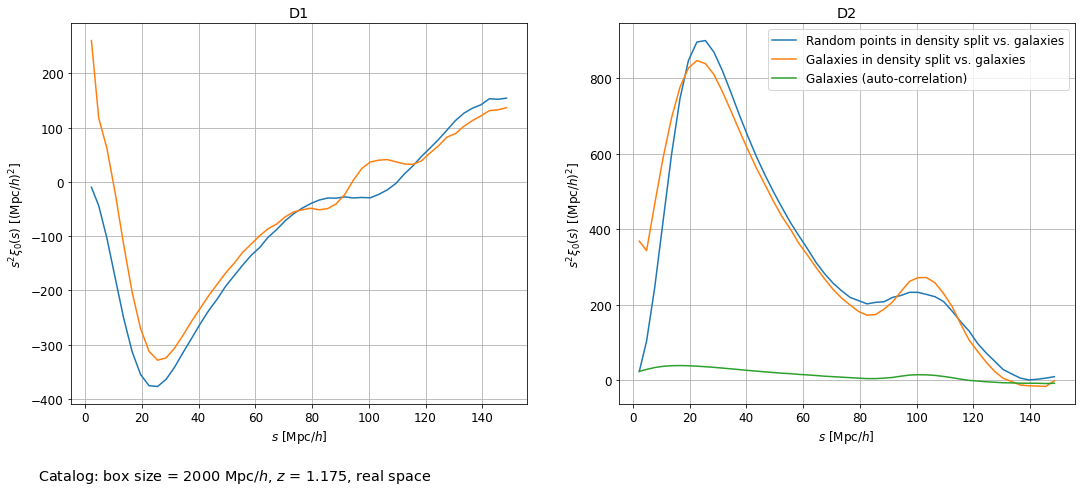

In [21]:
plt.rcParams["figure.figsize"] = (18, 7)
fig, axes = plt.subplots(1, 2)

for i in range(len(subset_names)):
    s, xiell= results_load[i].get_corr(ells=ells, return_sep=True)
    s_gg, xiell_gg= results_load_gg[i].get_corr(ells=ells, return_sep=True)

    ax = axes[i]

    ax.plot(s, s**2 * xiell[0], label='Random points in density split vs. galaxies')
    ax.plot(s, s**2 * xiell_gg[0], label='Galaxies in density split vs. galaxies')
    ax.grid(True)
    ax.set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
    ax.set_ylabel(r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
    ax.set_title(subset_names[i])

xiell_2PCF = result.get_corr(ells=ells, return_sep=False, return_cov=False)
axes[1].plot(s, s**2 * xiell_2PCF[0], label='Galaxies (auto-correlation)')

plt.suptitle('Catalog: box size = {:.0f} Mpc/$h$, $z$ = {:.3f}, '.format(boxsize, z) + rsd_info,
             ha='left', x=0.1, y=0)

plt.legend()
plt.show()